# Data Cleaning and Summary Statistics
In this notebook, I clean the data and look at some exploratory visualizations. I found some interesting observations (non-English publication titles), and removed wrong profiles and problematic observations. I then present a scatterplot to explore the relationship between age and number of publications, and word clouds. 

In [2]:
import csv
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10,6)

In [3]:
datcsv = open('data.txt','r')
dat = csv.reader(datcsv, delimiter = ' ',quotechar='"')
df = pd.DataFrame(next(dat))
df = df.transpose()

for i in dat:
    df_ = pd.DataFrame([i])
    df = pd.concat([df, df_])
    
datcsv.close()

I read the data in using a line-by-line method because pd.read_csv failed due to encoding issues. This may be because of non-English publication titles.

In [4]:
df.columns = ['school', 'name', 'citedby','title', 'year']
df['year'] = pd.to_numeric(df['year'])
df['citedby'] = pd.to_numeric(df['citedby'])

In [5]:
df.iloc[[1467, 1736, 4223, 6591]]

,school,name,citedby,title,year
0,Davis,Kueltz,1,Experimentelle Untersuchungen zur Funktion der...,1992
0,Davis,Medrano,3,Manipulación de la curva de lactación y de la ...,2006
0,TAMU,Tedeschi,0,Aplicación de Modelos en el Estudio de Dinámic...,2011
0,Florida,Binelli,7,Produção de animais transgênicos por transferê...,2008


I found these by looking through the dataset by hand. These seem like legitimate publication titles. It's not possible/practical to remove them all by hand, so I will leave them. When using knn and leave-one-out cross validation with a non-English test sample, the neighbors will probably be meaningless, so the MSE for these observations would likely be very high. However, since there are not too many of these, the average MSE should not be affected too much.

Another thing that I needed to check by hand is the correctness of the profiles. I have some experience in the field of animal science, and the wrong profiles were in math and computer science, so it was fairly obvious.

I went to Google Scholar to see what went wrong with these particular searches. I found out that the issue was that these two people had very common names with no middle initial available, so there were professors at the same universities with their names.

I will remove the two wrong profiles.

In [6]:
# Drop out all observations that are for the wrong person
df = df[~((df.name == "Cheng") & (df.school == "Davis"))]
df = df[~((df.name == "Davis") & (df.school == "Ohio"))]

Next let's look at publications per year.

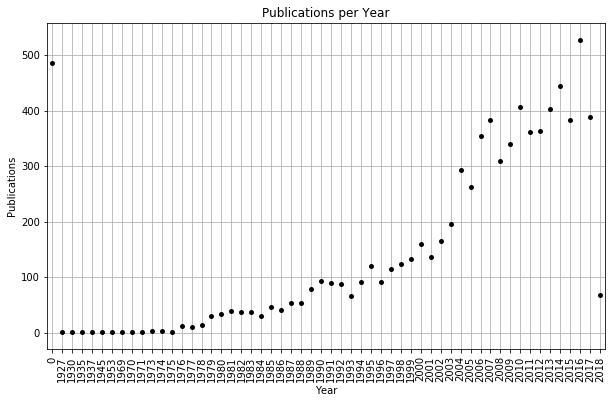

In [7]:
titles_per_year = pd.DataFrame(df.groupby(['year'])['title'].count())
titles_per_year = titles_per_year.reset_index()

g = sns.stripplot(x = "year", y ="title", data = titles_per_year, color = "black")
g.set(title = "Publications per Year", xlabel = "Year", ylabel = "Publications")
g.axes.xaxis.grid(True)
g.axes.yaxis.grid(True)
plt.xticks(rotation=90)

plt.show()

The observations with year 0 are known to be issues with reading in data, so those should be removed. 

There are also some papers in the 1920's and 30's. These cannot be legitimate because I chose only active (not Emiriti) professors, and they weren't even born yet in 1927. The oldest professors in the UC Davis animal science department got their PhD's in the 1970's so based on this, I decided that a reasonable cutoff would be 1960. Any years before that should be considered a mistake by scholarly in reading the data from Google Scholar. The number of publications per year seems to be steadily growing, but this may be due to having more professors, not necessarily each professor publishing at a higher rate.

In [8]:
# Get rid of rows that are mistakes (including 0)
df = df[df.year > 1960]

In [9]:
# Export the cleaned data for use in the next notebook
df.to_csv("cleaned.txt", sep=' ', index=False, header=False)

## Now that the data is clean, we can start exploring

In [10]:
df.name.nunique()

56

Out of the 183 professors from the previous notebook (data_acquisition.ipynb), only 56 of them had Google Scholar profiles set up. 

In [9]:
df.groupby('school').agg({'name': 'nunique'}).reset_index()

,school,name
0,Cornell,2
1,Davis,12
2,Florida,22
3,Ohio,7
4,TAMU,14


This shows how many professors came from each school. There are very few Cornell and Ohio State professors in this dataset.

In [11]:
df.groupby(['school'])['title'].count()

school
Cornell     291
Davis      1494
Florida    2512
Ohio        426
TAMU       2769
Name: title, dtype: int64

Above is the number of publications for each school. Not surprisingly, the schools with fewer professors had fewer publications. However, Texas A&M professors seem to be more prolific on average, because there are only 14 of them, but they have more publications than the 22 professors at Florida, and almost twice as many publications as the 12 UC Davis professors.

Next let's look at the relationship between age and number of publications. Because scholarly returns every publication for a given profile, the number of publications returned for each professor is meaningful. However, it is natural that older professors would have more publications, since they have had more time. I don't have data for age or the year they got their PhD, so I will use the year of their first paper as a measure of how old they are. This seems like a reasonable measure of age because most people publish their first paper during grad school.

In [6]:
# Count up the total number of publications for each professor
c = pd.DataFrame(df.groupby(['school','name'])['title'].size())
c = c.reset_index()

# Get the year of the first paper for each professor
s = pd.DataFrame(df.groupby(['school','name'])['year'].min())
s = s.reset_index()

total = pd.merge(c,s)
total.columns = ['school', 'name', 'count', 'start_year']
total

,school,name,count,start_year
0,Cornell,Amburgh,188,1981
1,Cornell,Ketterings,103,1997
2,Davis,Berger,157,1979
3,Davis,Eadie,121,1979
4,Davis,Horback,14,2010
5,Davis,Kebreab,431,1999
6,Davis,Kueltz,110,1991
7,Davis,Liu,41,2006
8,Davis,Makagon,31,2005
9,Davis,Medrano,303,1973


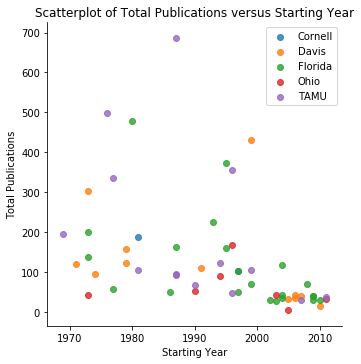

In [9]:
s = sns.lmplot(x = "start_year", y = "count", hue='school', data=total, 
               fit_reg=False, legend=False)
s. set(title = "Scatterplot of Total Publications versus Starting Year", 
       xlabel = "Starting Year", ylabel = "Total Publications")
plt.legend(loc='upper right')

plt.show()

I expected that older professors would have more papers. This trend seems generally true, but older professors seem to have a lot of variation, while younger professors have less variation and tend to be lower. There are a few very prolific professors at Texas A&M and Florida State.

# Word Clouds
Word clouds would be helpful to see what topics are commonly studied at the different universities (I'll skip Cornell and Ohio due to low numbers of professors at those schools). I am interested to know if the word clouds look radically different at the different universities.

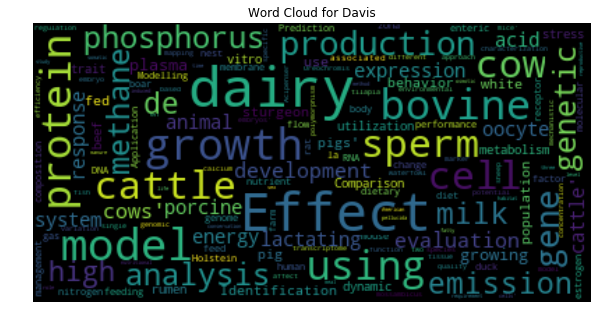

In [56]:
davis = df[df.school == "Davis"]
wordcloud = WordCloud(max_font_size=40, 
                      collocations=False).generate(str(davis["title"].tolist()))

plt.figure()
plt.title("Word Cloud for Davis")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
#plt.savefig('davis_word_cloud.png', dpi=1200) # to save high-res image
plt.show()

Insights about the Davis word cloud:
- "Dairy" is very large. This does not surprise me, because California has a very large dairy industry, especially in the Central Valley and Souther California. "Cow" is also fairly large. The term cow refers to an adult female bovine, which is the gender primarily associated with dairies (because males and young animals don't make milk).
- "Protein" is also very large but I think this can have multiple contexts--some professors study protein expression levels in cells (for example during different environmental conditions) and some professors study protein levels fed in the diet and how those can affect an animal's health and growth.

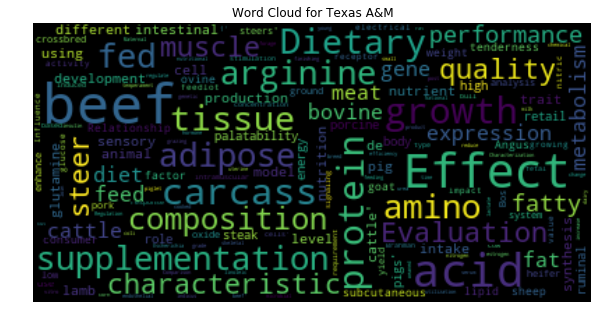

In [57]:
tamu = df[df.school == "TAMU"]
wordcloud = WordCloud(max_font_size=40, 
                      collocations=False).generate(str(tamu["title"].tolist()))
plt.figure()
plt.title("Word Cloud for Texas A&M")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Insights about the Texas A&M word cloud:  
- The major theme in this word cloud is "beef". "Steer" is also fairly large. A steer is a castrated male, and this is the gender primarily associated with the beef industry. 
- "Carcass", which refers to the slaughtered animal, is fairly large, indicating that meat quality is an important research area at Texas A&M. "Adipose" and "quality" are also related to meat quality.
- "Dietary", "arginine", "fatty", "amino", and "supplementation" are large, and this is likely due to studies about different diets being fed to animals.

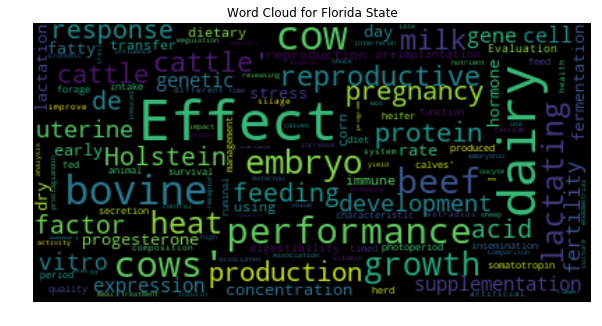

In [58]:
florida = df[df.school == "Florida"]
wordcloud = WordCloud(max_font_size=40, 
                      collocations=False).generate(str(florida["title"].tolist()))
plt.figure()
plt.title("Word Cloud for Florida State")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Insights about the Florida word cloud:  
- This word cloud seems to be a blend of the two previous word clouds, showing both "dairy" and "beef".
- Words like "embryo", "reproductive", "pregnancy", "uterine", and "vitro" indicate that reproductive physiology is important.
- I had expected to see more words relating to fish or marine mammals since schools located near water typically have some professors that study marine life. One possible explanation I thought of is that there is a separate marine science department, but that doesn't seem to be the case.

Out of personal curiosity, I wanted make a word cloud for my favorite professor. (I have 7 favorite professors, but this one is my favorite who has a Google Scholar profile.) He has 110 publications, so I think that should be enough to make a meaningful word cloud with. 

If I had to summarize what I think he studies, I would say he studies fish (tilapia and sticklebacks) and their protein expression levels in response to environmental stressors such as temperature and salinity. Let's see how accurately the word cloud reflects this.

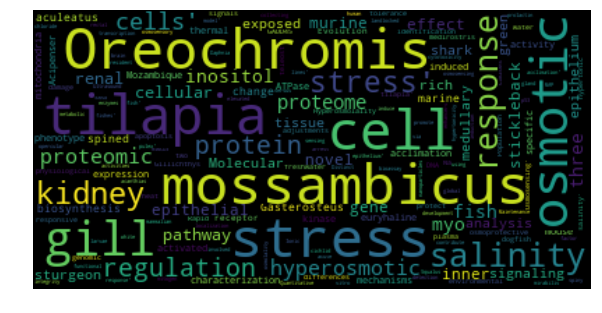

In [15]:
fav_prof = df[df.name == "Kueltz"]
wordcloud = WordCloud(max_font_size=40, 
                      collocations=False).generate(str(fav_prof["title"].tolist()))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

The giant yellow words are the scientific name for tilapia, and "tilapia" itself is large, while "stickleback" is considerably smaller. "Stress" is large, as are "osmotic" and "salinity", which is consistent with what I expected, but temperature and heat seem to not be reflected here. "Kidney" is larger than I would have expected but I think this is a reflection of his previous work (not related to fish).